Elmo Embedding + Bi-LSTM +BN + FC

In [53]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))

['ner.csv', 'ner_dataset.csv']


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("../input/ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [55]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words ## how many data

35179

In [56]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [57]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [58]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [59]:
sentences = getter.sentences
print(len(sentences))

47959


In [60]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


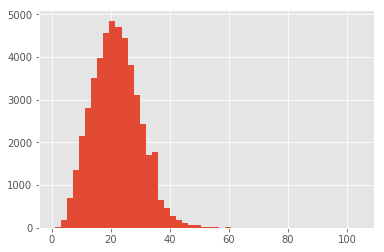

In [61]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [62]:
words2index = {w:i for i,w in enumerate(words)} ## create index for NN
tags2index = {t:i for i,t in enumerate(tags)} ## create index for NN
# print(words2index['London'])
# print(tags2index['B-geo'])
print(tags2index)

{'B-geo': 0, 'I-eve': 1, 'B-art': 2, 'I-org': 3, 'B-org': 4, 'B-eve': 5, 'I-art': 6, 'I-tim': 7, 'I-per': 8, 'I-gpe': 9, 'B-per': 10, 'B-nat': 11, 'I-geo': 12, 'I-nat': 13, 'B-tim': 14, 'B-gpe': 15, 'O': 16}


In [63]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [64]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences] # s : sequence, w: ex: ('apple' , 'O')
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])  ## value=tags2index["O"] is the padding value
print(len(sentences))
print(sentences[2])

47959
[('Helicopter', 'O'), ('gunships', 'O'), ('Saturday', 'B-tim'), ('pounded', 'O'), ('militant', 'O'), ('hideouts', 'O'), ('in', 'O'), ('the', 'O'), ('Orakzai', 'B-geo'), ('tribal', 'O'), ('region', 'O'), (',', 'O'), ('where', 'O'), ('many', 'O'), ('Taliban', 'B-org'), ('militants', 'O'), ('are', 'O'), ('believed', 'O'), ('to', 'O'), ('have', 'O'), ('fled', 'O'), ('to', 'O'), ('avoid', 'O'), ('an', 'O'), ('earlier', 'O'), ('military', 'O'), ('offensive', 'O'), ('in', 'O'), ('nearby', 'O'), ('South', 'B-geo'), ('Waziristan', 'I-geo'), ('.', 'O')]


In [65]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [66]:
batch_size = 32 ################# batch size
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [67]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [68]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [69]:
!pip install livelossplot


In [76]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras import initializers, regularizers, constraints
from livelossplot.keras import PlotLossesCallback
from keras.layers.normalization import BatchNormalization

In [77]:
act = 'relu'
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.3, dropout=0.5))(embedding)
x = Bidirectional(LSTM(units=256, return_sequences=True,
                       recurrent_dropout=0.3, dropout=0.5))(x)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.3, dropout=0.5))(embedding)
x_rnn = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.3, dropout=0.5))(x_rnn)
x = add([x, x_rnn])  # residual connection to the first biLSTM
x = Dense(256, activation = act)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation = act)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [78]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [79]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 50, 1024)     0           input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 50, 1024)     6295552     lambda_4[0][0]                   
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 50, 1024)     6295552     lambda_4[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [80]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

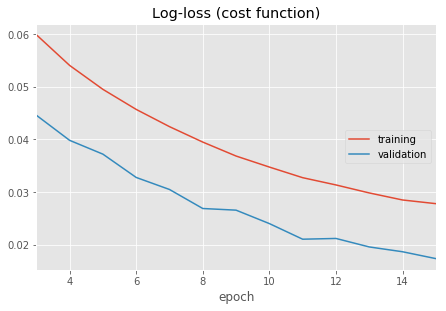

Log-loss (cost function):
training   (min:    0.028, max:    0.266, cur:    0.028)
validation (min:    0.017, max:    0.065, cur:    0.017)


In [81]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=15, verbose=1, callbacks=[PlotLossesCallback()])

In [82]:
!pip install seqeval

  Stored in directory: /tmp/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [83]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 65s 14ms/step


In [84]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [85]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.2%


In [86]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      per       0.78      0.81      0.80      1677
      org       0.72      0.69      0.70      2061
      geo       0.84      0.91      0.87      3720
      gpe       0.96      0.93      0.95      1591
      tim       0.84      0.87      0.85      2148
      art       0.17      0.14      0.15        49
      eve       0.28      0.33      0.31        33
      nat       0.38      0.23      0.29        22

micro avg       0.82      0.84      0.83     11301
macro avg       0.82      0.84      0.83     11301

